<a href="https://colab.research.google.com/github/myndaaa/Natural-Language-Processing/blob/main/FNLP_Tutorial7_mssha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**COS30081 FNLP Tutorial 7: Question**

##**Lab Task Submission at bottom #PassTask6**
## **Name:Mysha nahiyan Shemontee**
## **Student ID:102773618**


**Pass Task Description:**

There are several forms of LSTM that can be used. At the very basic level a variation of using LSTM would be stack LSTM layers together. A sample code is given below on how it can be easily done using keras.

Now try to adapt either from  jupyter notebook 7b or 7c to stack 2, 3 or more layers togethers. Use the same datasets given in the notebook. Include your scripts here. Also Write down your observations (time, performance) [<50 words]

**Additional & Optional:**
You can try to implement other forms of LSTM such as GRU and bidirectional LSTM as well besides stacking.


In [42]:
# example stacking
#model.add(LSTM(num_neurons, return_sequences=True, input_shape=X[0].shape))
#model.add(LSTM(num_neurons_2, return_sequences=True))

In [43]:
!nvidia-smi

Sat May 25 19:35:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |   2183MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [44]:
import os
import re
import tarfile
import requests
import tqdm
import numpy as np
import glob
from random import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, LSTM

In [45]:
BIG_URLS = {
    'w2v': (
        'https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1',
    ),
    'slang': (
        'https://www.dropbox.com/s/43c22018fbfzypd/slang.csv.gz?dl=1',
        117633024,
    ),
    'tweets': (
        'https://www.dropbox.com/s/5gpb43c494mc8p0/tweets.csv.gz?dl=1',
        311725313,
    ),
    'lsa_tweets': (
        'https://www.dropbox.com/s/rpjt0d060t4n1mr/lsa_tweets_5589798_2003588x200.tar.gz?dl=1',
        3112841563,
    ),
    'imdb': (
        'https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1',
        3112841563,
    ),
}

In [46]:
# These functions are part of the nlpia package which can be pip installed and run from there.
def dropbox_basename(url):
    filename = os.path.basename(url)
    match = re.findall(r'\?dl=[0-9]$', filename)
    if match:
        return filename[:-len(match[0])]
    return filename

def download_file(url, data_path='.', filename=None, size=None, chunk_size=4096, verbose=True):
    """Uses stream=True and a reasonable chunk size to be able to download large (GB) files over https"""
    if filename is None:
        filename = dropbox_basename(url)
    file_path = os.path.join(data_path, filename)
    if url.endswith('?dl=0'):
        url = url[:-1] + '1'  # noninteractive download
    if verbose:
        tqdm_prog = tqdm
        print('requesting URL: {}'.format(url))
    else:
        tqdm_prog = no_tqdm
    r = requests.get(url, stream=True, allow_redirects=True)
    size = r.headers.get('Content-Length', None) if size is None else size
    print('remote size: {}'.format(size))

    # stat = path_status(file_path)
    # print('local size: {}'.format(stat.get('size', None)))
    # if stat['type'] == 'file' and stat['size'] == size:  # TODO: check md5 or get the right size of remote file
    #     r.close()
    #     return file_path

    print('Downloading to {}'.format(file_path))

    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:  # filter out keep-alive chunks
                f.write(chunk)

    r.close()
    return file_path

def untar(fname):
    if fname.endswith("tar.gz"):
        with tarfile.open(fname) as tf:
            tf.extractall()
    else:
        print("Not a tar.gz file: {}".format(fname))

In [47]:
download_file(BIG_URLS['w2v'][0])
untar(download_file(BIG_URLS['imdb'][0]))

requesting URL: https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1
remote size: 1647046227
requesting URL: https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1
remote size: 84125825


In [48]:
def pre_process_data(filepath):
    """
    This is dependent on your training data source but we will try to generalize it as best as possible.
    """
    positive_path = os.path.join(filepath, 'pos')
    negative_path = os.path.join(filepath, 'neg')

    pos_label = 1
    neg_label = 0

    dataset = []

    for filename in glob.glob(os.path.join(positive_path, '*.txt')):
        with open(filename, 'r') as f:
            dataset.append((pos_label, f.read()))

    for filename in glob.glob(os.path.join(negative_path, '*.txt')):
        with open(filename, 'r') as f:
            dataset.append((neg_label, f.read()))

    shuffle(dataset)

    return dataset

def collect_expected(dataset):
    """ Peel of the target values from the dataset """
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected


dataset = pre_process_data('./aclImdb/train')
expected = collect_expected(dataset)


def avg_len(data):
    total_len = 0
    for sample in data:
        total_len += len(sample[1])
    return total_len/len(data)

def clean_data(data):
    """Shift to lower case, replace unknowns with UNK, and listify"""
    new_data = []
    VALID = 'abcdefghijklmnopqrstuvwxyz0123456789"\'?!.,:; '
    for sample in data:
        new_sample = []
        for char in sample[1].lower():
            if char in VALID:
                new_sample.append(char)
            else:
                new_sample.append('UNK')
        new_data.append(new_sample)
    return new_data

def char_pad_trunc(data, maxlen=1500):
    """ We truncate to maxlen or add in PAD tokens """
    new_dataset = []
    for sample in data:
        if len(sample) > maxlen:
            new_data = sample[:maxlen]
        elif len(sample) < maxlen:
            pads = maxlen - len(sample)
            new_data = sample + ['PAD'] * pads
        else:
            new_data = sample
        new_dataset.append(new_data)
    return new_dataset

def create_dicts(data):
    """ Modified from Keras LSTM example"""
    chars = set()
    for sample in data:
        chars.update(set(sample))
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))
    return char_indices, indices_char

def onehot_encode(dataset, char_indices, maxlen=500):
    """
    One-hot encode the tokens

    Args:
        dataset list of lists of tokens
        char_indices
          dictionary of {key=character,
            value=index to use encoding vector}
        maxlen int Length of each sample

    Return:
       np array of shape (samples, tokens, encoding length)
    """

    X = np.zeros((len(dataset), maxlen, len(char_indices.keys())))
    for i, sentence in enumerate(dataset):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
    return X

In [49]:
avg_len(dataset)

1325.06964

In [50]:
listified_data = clean_data(dataset)
common_length_data = char_pad_trunc(listified_data, maxlen=500)
char_indices, indices_char = create_dicts(common_length_data)
char_indices1, indices_char1 = create_dicts(common_length_data)
encoded_data = onehot_encode(common_length_data, char_indices, 500)

In [51]:
split_point = int(len(encoded_data)*.1)
split_point2 = int(len(encoded_data)*.15)

x_train = np.array(encoded_data[:split_point])
y_train = np.array(expected[:split_point])
x_test = np.array(encoded_data[split_point:split_point2])
y_test = np.array(expected[split_point:split_point2])

In [52]:
len(dataset)

25000

In [53]:
num_neurons = 40
num_neurons_2 = 30  # Number of neurons in the second layer
num_neurons_3 = 20  # Number of neurons in the third layer
maxlen = 500
model = Sequential()
model.add(LSTM(num_neurons, return_sequences=True, input_shape=(maxlen, len(char_indices.keys()))))
model.add(LSTM(num_neurons_2, return_sequences=True))  # Second LSTM layer stacked
model.add(LSTM(num_neurons_3, return_sequences=True))  # Third LSTM layer stacked
model.add(Dropout(.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 500, 40)           14080     
                                                                 
 lstm_12 (LSTM)              (None, 500, 30)           8520      
                                                                 
 lstm_13 (LSTM)              (None, 500, 20)           4080      
                                                                 
 dropout_3 (Dropout)         (None, 500, 20)           0         
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 36681 (143.29 KB)
Trainable params: 3668

In [54]:
batch_size = 16
epochs = 10

In [55]:
#model.fit(x_train, y_train, batch_size=batch_size,epochs=epochs,validation_data=(x_test, y_test))
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/10
157/157 [==============================] - 14s 55ms/step - loss: 0.6976 - accuracy: 0.4832 - val_loss: 0.7009 - val_accuracy: 0.4752
Epoch 2/10
157/157 [==============================] - 8s 50ms/step - loss: 0.6888 - accuracy: 0.5416 - val_loss: 0.6987 - val_accuracy: 0.4936
Epoch 3/10
157/157 [==============================] - 9s 60ms/step - loss: 0.6737 - accuracy: 0.5784 - val_loss: 0.7086 - val_accuracy: 0.5080
Epoch 4/10
157/157 [==============================] - 7s 45ms/step - loss: 0.6548 - accuracy: 0.6052 - val_loss: 0.7148 - val_accuracy: 0.5128
Epoch 5/10
157/157 [==============================] - 8s 50ms/step - loss: 0.6398 - accuracy: 0.6272 - val_loss: 0.7266 - val_accuracy: 0.5192
Epoch 6/10
157/157 [==============================] - 9s 58ms/step - loss: 0.6228 - accuracy: 0.6516 - val_loss: 0.7408 - val_accuracy: 0.5224
Epoch 7/10
157/157 [==============================] - 9s 57ms/step - loss: 0.6076 - accuracy: 0.6708 - val_loss: 0.7608 - val_accuracy: 0.515

In [56]:
model_structure = model.to_json()
with open("task6.json", "w") as json_file:
  json_file.write(model_structure)
model.save_weights("task6.h5")

In [57]:
from keras.models import model_from_json
with open("task6.json", "r") as json_file:
  json_string = json_file.read()
model = model_from_json(json_string)
model.load_weights('task6.h5')

In [58]:
def clean_data_single(data):
  """Shift to lower case, replace unknowns with UNK, and listify"""
  new_data = []
  VALID = 'abcdefghijklmnopqrstuvwxyz0123456789"\'?!.,:; '
  new_sample = []
  for char in data.lower():
    if char in VALID:
      new_sample.append(char)
    else:
      new_sample.append('UNK')
  return new_sample


In [59]:
def char_pad_trunc2(data, maxlen=500):
  """ We truncate to maxlen or add in PAD tokens """
  sample=data
  if len(sample) > maxlen:
    new_data = sample[:maxlen]
  elif len(sample) < maxlen:
    pads = maxlen - len(sample)
    new_data = sample + ['PAD'] * pads
  else:
    new_data = sample
  return new_data

In [60]:
def onehot_encode2(dataset, char_indices, maxlen=500):
  """
  One-hot encode the tokens

  Args:
    dataset list of lists of tokens
    char_indices
      dictionary of {key=character,
        value=index to use encoding vector}
    maxlen int Length of each sample

  Return:
   np array of shape (samples, tokens, encoding length)
  """

  X = np.zeros((1, maxlen, len(char_indices.keys())))
  for t, char in enumerate(dataset):
    if char=='PAD':
      break
    X[0, t, char_indices[char]] = 1
  return X

In [61]:
def create_dicts2(data):
  """ Modified from Keras LSTM example"""
  chars = set()
  for sample in data:
    chars.update(set(sample))
  char_indices = dict((c, i) for i, c in enumerate(chars))
  indices_char = dict((i, c) for i, c in enumerate(chars))
  return char_indices, indices_char

In [62]:
sample_1 = "The sun is shining brightly, birds are chirping, and the flowers are blooming."


In [63]:
listified_data = clean_data_single(sample_1)
common_length_data = char_pad_trunc2(listified_data, maxlen=500)
char_indices, indices_char = create_dicts(common_length_data)
encoded_data = onehot_encode2(common_length_data, char_indices1, 500)
len(encoded_data)

1

In [64]:
char_indices, indices_char = create_dicts(common_length_data)

In [65]:
print("Raw output of sigmoid function: {}".format(model.predict(encoded_data)))

1/1 [==============================] - 1s 904ms/step
Raw output of sigmoid function: [[0.5434831]]


In [66]:
#Initialising basic values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(accuracy))

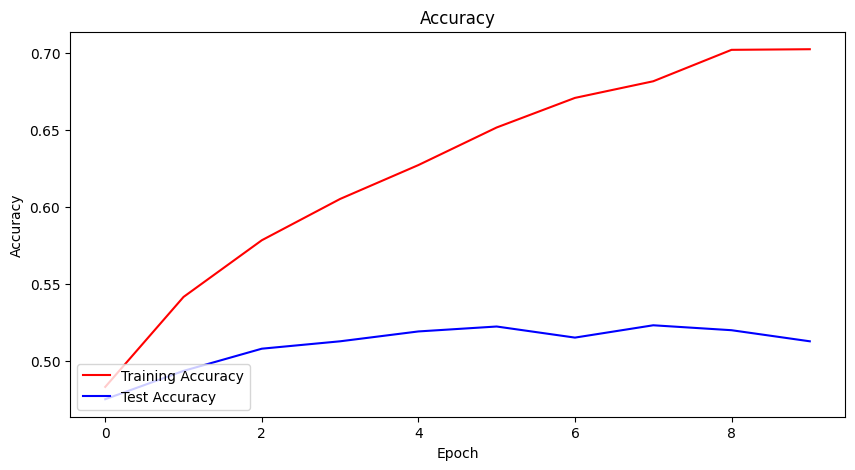

Text(0.5, 1.0, 'Training and Test loss')

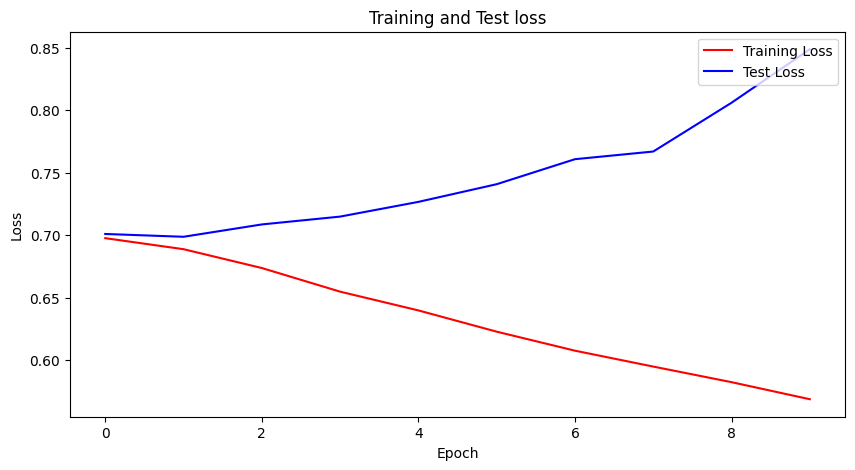

In [67]:
#Plotting the graph for the accuracy of training and testing

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
plt.plot(epochs, accuracy, 'r', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b', label="Test Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower left')
plt.show()

#Plotting the graph for the loss of training and testing
fig2 = plt.figure(figsize=(10,5))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Test Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test loss')

In [69]:
# Print out the accuracy and loss values
print("Training Accuracy:", history.history['accuracy'])
print("Validation Accuracy:", history.history['val_accuracy'])
print("Training Loss:", history.history['loss'])
print("Validation Loss:", history.history['val_loss'])


Training Accuracy: [0.4832000136375427, 0.5415999889373779, 0.5784000158309937, 0.6051999926567078, 0.6272000074386597, 0.6516000032424927, 0.670799970626831, 0.6815999746322632, 0.7020000219345093, 0.7024000287055969]
Validation Accuracy: [0.47519999742507935, 0.4936000108718872, 0.5080000162124634, 0.5127999782562256, 0.5192000269889832, 0.5224000215530396, 0.5152000188827515, 0.5231999754905701, 0.5199999809265137, 0.5127999782562256]
Training Loss: [0.697587251663208, 0.6887640357017517, 0.6737056374549866, 0.6547964215278625, 0.6397744417190552, 0.6227813959121704, 0.6075643301010132, 0.5948531031608582, 0.5823776125907898, 0.5687242150306702]
Validation Loss: [0.7009432911872864, 0.6987012624740601, 0.7085766792297363, 0.7148441672325134, 0.7266231775283813, 0.740763247013092, 0.7607766389846802, 0.7669086456298828, 0.8059374094009399, 0.8487679958343506]


# **Observations**:
## The model achieved an accuracy of around 70% on the training data and around 52% on the validation data after 10 epochs. The training loss decreased from 0.6976 to 0.5687, while the validation loss increased from 0.7009 to 0.8488. this is indicating a slightly positive sentiment.Overall, the model shows moderate performance but may benefit from further tuning.



